In [1]:
# This Python 3 environment comes with many helpful analytics libraries installed
# It is defined by the kaggle/python Docker image: https://github.com/kaggle/docker-python
# For example, here's several helpful packages to load

import numpy as np # linear algebra
import pandas as pd # data processing, CSV file I/O (e.g. pd.read_csv)

# Input data files are available in the read-only "../input/" directory
# For example, running this (by clicking run or pressing Shift+Enter) will list all files under the input directory

import os
for dirname, _, filenames in os.walk('/kaggle/input'):
    for filename in filenames:
        print(os.path.join(dirname, filename))

# You can write up to 20GB to the current directory (/kaggle/working/) that gets preserved as output when you create a version using "Save & Run All" 
# You can also write temporary files to /kaggle/temp/, but they won't be saved outside of the current session

/kaggle/input/retail-sales-forecasting/mock_kaggle.csv


As indicated by the context of the dataset:
> *This dataset contains lot of historical sales data. It was extracted from a Brazilian top retailer and has many SKUs and many stores. The data was transformed to protect the identity of the retailer*.

In this notebook we'll analyze the data and perform predictions (first for all the features, then for the sales specifically) testing different models (ARIMA, SARIMA, XGBRegressor).

<h2>Importing libraries</h2>

In [2]:
import warnings
warnings.simplefilter(action='ignore')
import datetime
import matplotlib.pyplot as plt
import seaborn as sns
from statsmodels.tsa.arima.model import ARIMA
from statsmodels.tsa.statespace.sarimax import SARIMAX
from statsmodels.tsa.stattools import adfuller, kpss
from statsmodels.tsa.seasonal import seasonal_decompose
from statsmodels.graphics.tsaplots import plot_acf, plot_pacf
from pandas.plotting import autocorrelation_plot, scatter_matrix
from sklearn.metrics import mean_absolute_error, mean_squared_error
from xgboost import XGBRegressor

<h2>Loading data</h2>

In [3]:
df = pd.read_csv('/kaggle/input/retail-sales-forecasting/mock_kaggle.csv', parse_dates = ['data'])

df.head()

,data,venda,estoque,preco
0,2014-01-01,0,4972,1.29
1,2014-01-02,70,4902,1.29
2,2014-01-03,59,4843,1.29
3,2014-01-04,93,4750,1.29
4,2014-01-05,96,4654,1.29


The columns name are in Portuguese, so we translate them in English for clarity:

In [4]:
df = df.rename(columns = {
    'data' : 'date',
    'venda' : 'sales',
    'estoque' : 'stock',
    'preco' : 'price'
})

In [5]:
df.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 937 entries, 0 to 936
Data columns (total 4 columns):
 #   Column  Non-Null Count  Dtype         
---  ------  --------------  -----         
 0   date    937 non-null    datetime64[ns]
 1   sales   937 non-null    int64         
 2   stock   937 non-null    int64         
 3   price   937 non-null    float64       
dtypes: datetime64[ns](1), float64(1), int64(2)
memory usage: 29.4 KB


<h2>EDA</h2>

In [6]:
df.nunique().sort_values(ascending=False)

date     937
stock    724
sales    261
price     55
dtype: int64

<h3>Checking missing/duplicate values</h3>

In [7]:
date_range = pd.date_range(start = '2014-01-01', end='2016-07-31', freq='D')
date_missing = date_range[~date_range.isin(df['date'])]

check_missing = len(date_missing) > 0
print('Missing days: ', check_missing)
print(f'{len(date_missing)} days missing:\n{date_missing.values}') if check_missing else print('No days missing!')

#CHECK DUPLICATE DATES
date_vc = df['date'].value_counts()
date_duplicates = date_vc[date_vc > 1]
print('No duplicates dates!') if len(date_duplicates) == 0 else print(f'Duplicates dates detected:\n{date_duplicates.index}')

Missing days:  True
6 days missing:
['2014-01-17T00:00:00.000000000' '2014-02-10T00:00:00.000000000'
 '2014-02-11T00:00:00.000000000' '2014-03-04T00:00:00.000000000'
 '2014-03-15T00:00:00.000000000' '2014-08-25T00:00:00.000000000']
No duplicates dates!


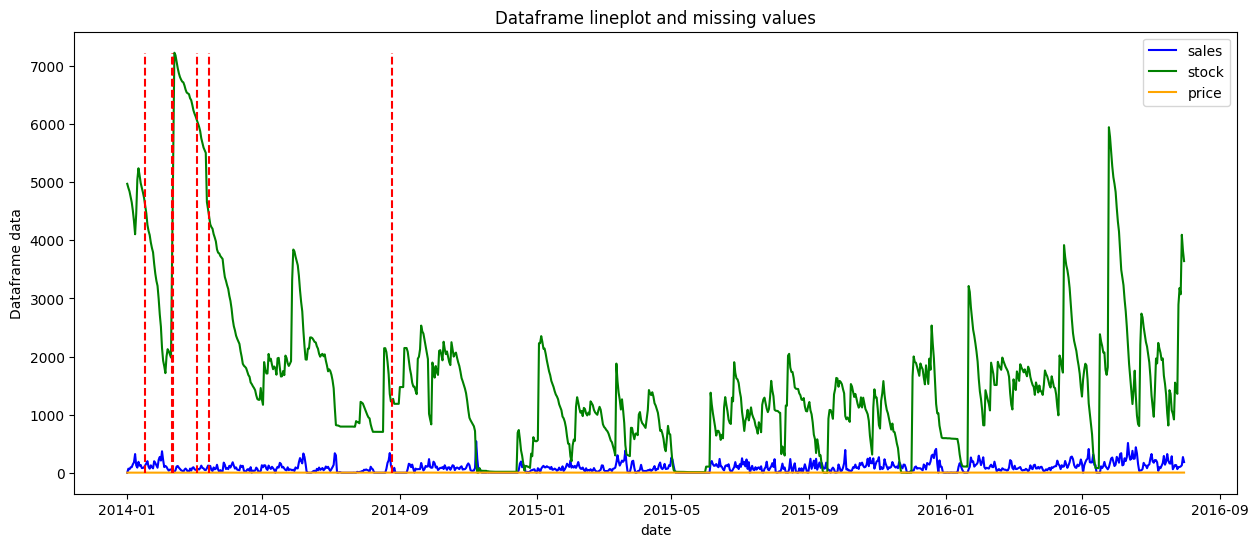

In [8]:
df.set_index('date', inplace=True)
merged_df = df.reindex(date_range)
missing_dates_mask = np.where(np.isnan(merged_df['price']))[0]

_, ax = plt.subplots(figsize=(15,6))
sns.lineplot(x = merged_df.index, y = merged_df.sales, color = 'blue', label = 'sales', ax=ax)
sns.lineplot(x = merged_df.index, y = merged_df.stock, color = 'green', label = 'stock', ax=ax)
sns.lineplot(x = merged_df.index, y = merged_df.price, color = 'orange', label = 'price', ax=ax)
ax.set_title('Dataframe lineplot and missing values')
plt.xlabel('date')
plt.ylabel('Dataframe data')
plt.legend()
plt.vlines(merged_df.index[missing_dates_mask], color='red', ymin = min(merged_df.min()), ymax = max(merged_df.max()), linestyle= '--')
plt.show()

There are just 6 missing values, so we find sufficient to adopt a forward-filling method to add them:

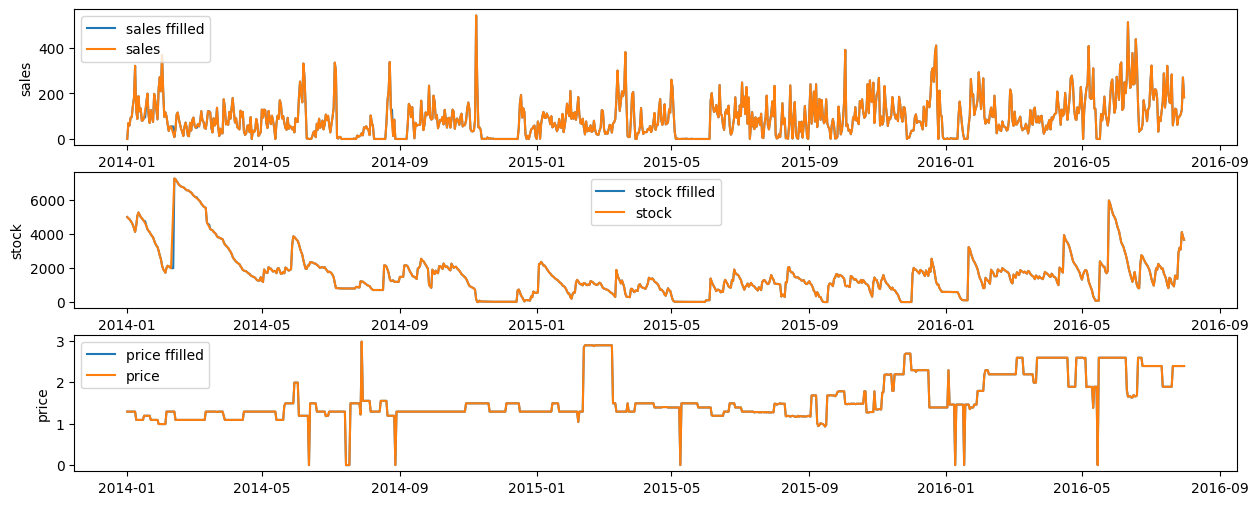

In [9]:
date_ff = merged_df.fillna(method='ffill')

_, axes = plt.subplots(3,1, figsize=(15,6))
for col, ax in zip(date_ff.columns, axes.ravel()):
    sns.lineplot(x = date_ff.index ,y = date_ff[col], ax=ax, label = f'{col} ffilled')
    sns.lineplot(x= merged_df.index, y = merged_df[col], ax=ax, label = col)
plt.legend()
plt.show()

In [10]:
date_ff.describe()

,sales,stock,price
count,943.000000,943.000000,943.000000
mean,90.492047,1619.854719,1.590223
std,80.469137,1367.603232,0.528663
min,0.000000,0.000000,0.000000
25%,33.500000,794.000000,1.290000
50%,76.000000,1356.000000,1.390000
75%,127.000000,1970.000000,1.880000
max,542.000000,7228.000000,2.980000


We split the data in a train and test dataframe:

In [11]:
TEST_SIZE = 60
train, test = date_ff[:-TEST_SIZE], date_ff[-TEST_SIZE:]
train.info()

<class 'pandas.core.frame.DataFrame'>
DatetimeIndex: 883 entries, 2014-01-01 to 2016-06-01
Freq: D
Data columns (total 3 columns):
 #   Column  Non-Null Count  Dtype  
---  ------  --------------  -----  
 0   sales   883 non-null    float64
 1   stock   883 non-null    float64
 2   price   883 non-null    float64
dtypes: float64(3)
memory usage: 27.6 KB


The correlation matrix below does not show significant linear correlation:

<Axes: >

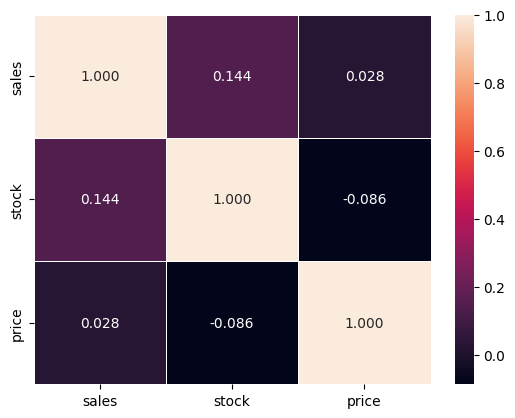

In [12]:
corr_matrix = train.corr()
sns.heatmap(corr_matrix, annot = True, fmt = '.3f', linewidth=0.5)

<h3>Check for stationarity</h3>

At this stage we work for all three variable (sales, stock and price); we check for the presence of unit root with both the Augmented Dickey Fuller test and the Kwiatkowski-Phillips-Schmidt-Shin test:

In [13]:
adf_df = pd.DataFrame()
for cname in train.columns:
    results = adfuller(train[cname].values, maxlag = 28)
    adf_df = pd.concat([adf_df, pd.DataFrame({'ADF': results[0], 'p-value' : results[1], 'Critical values': str(results[4])}, index=[cname])], axis=0)
adf_df

,ADF,p-value,Critical values
sales,-4.524908,0.000177,"{'1%': -3.43803040357387, '5%': -2.86493029595..."
stock,-3.838812,0.002534,"{'1%': -3.4377858660487277, '5%': -2.864822485..."
price,-4.438624,0.000253,"{'1%': -3.4378028154245515, '5%': -2.864829958..."


In [14]:
kpss_df = pd.DataFrame()
for cname in train.columns:
    results = kpss(train[cname].values)
    kpss_df = pd.concat([kpss_df, pd.DataFrame({'kpss': results[0], 'p-value' : results[1], 'Critical values': str(results[3])}, index=[cname])], axis=0)
kpss_df

/tmp/ipykernel_17/156752299.py:3: InterpolationWarning: The test statistic is outside of the range of p-values available in the
look-up table. The actual p-value is smaller than the p-value returned.

  results = kpss(train[cname].values)
/tmp/ipykernel_17/156752299.py:3: InterpolationWarning: The test statistic is outside of the range of p-values available in the
look-up table. The actual p-value is smaller than the p-value returned.

  results = kpss(train[cname].values)


,kpss,p-value,Critical values
sales,0.714419,0.012235,"{'10%': 0.347, '5%': 0.463, '2.5%': 0.574, '1%..."
stock,1.339207,0.010000,"{'10%': 0.347, '5%': 0.463, '2.5%': 0.574, '1%..."
price,2.054114,0.010000,"{'10%': 0.347, '5%': 0.463, '2.5%': 0.574, '1%..."


The p-value of the test is less than the significance level (0.05) then we reject the null hypothesis and infer that the time series has no unit roots and it is indeed stationary.

<h3>Autocorrelation Analysis</h3>

While sales autocorrelation decays in around one week, stock and price show a more persistent autocorrelation:

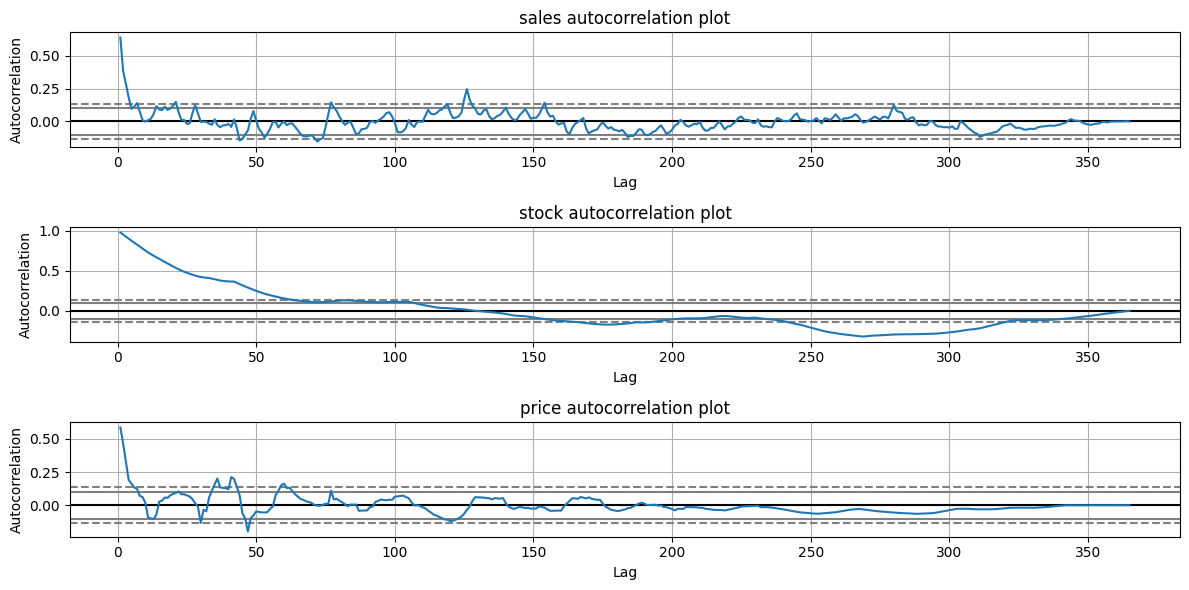

In [15]:
_, axes = plt.subplots(len(train.columns), 1, figsize=(12,6))
for cname, ax in zip(train.columns, axes.ravel()):
    autocorrelation_plot(train[cname].values[:365], ax=ax)
    ax.set_title(f'{cname} autocorrelation plot')
plt.tight_layout()
plt.show()

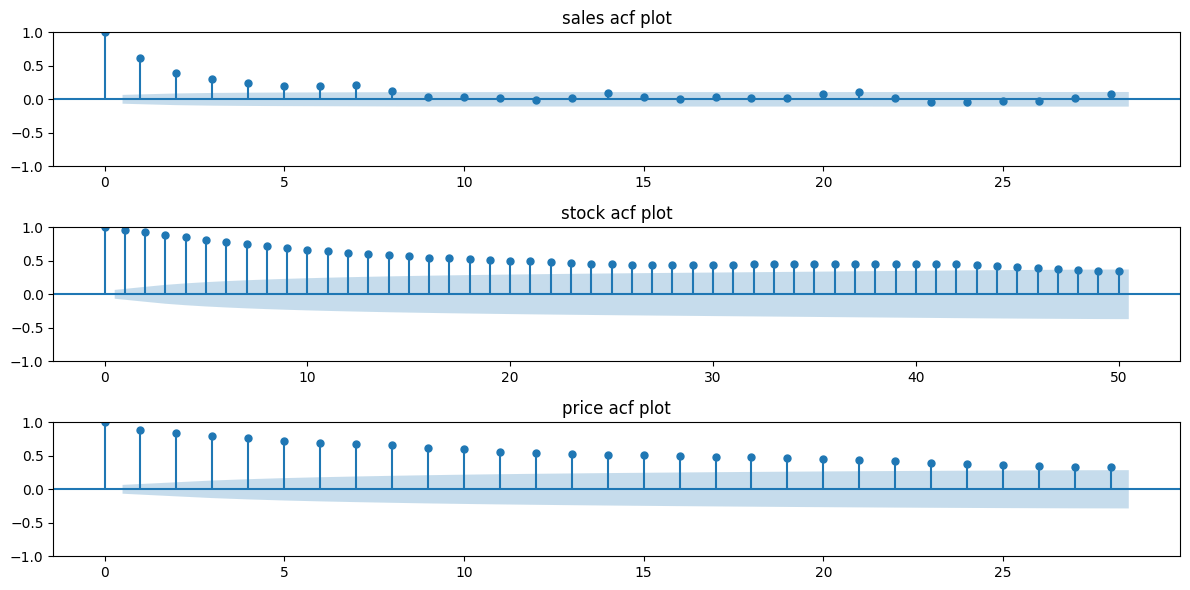

In [16]:
LAGS = [28, 50, 28]
_, axes = plt.subplots(len(train.columns), 1, figsize=(12,6))
for cname, ax, lags in zip(train.columns, axes.ravel(), LAGS):
    plot_acf(train[cname], lags = lags,  ax=ax)
    ax.set_title(f'{cname} acf plot')
plt.tight_layout()
plt.show()

The partial autocorrelation functions on the other hand return significance at only lag 1 and 2:

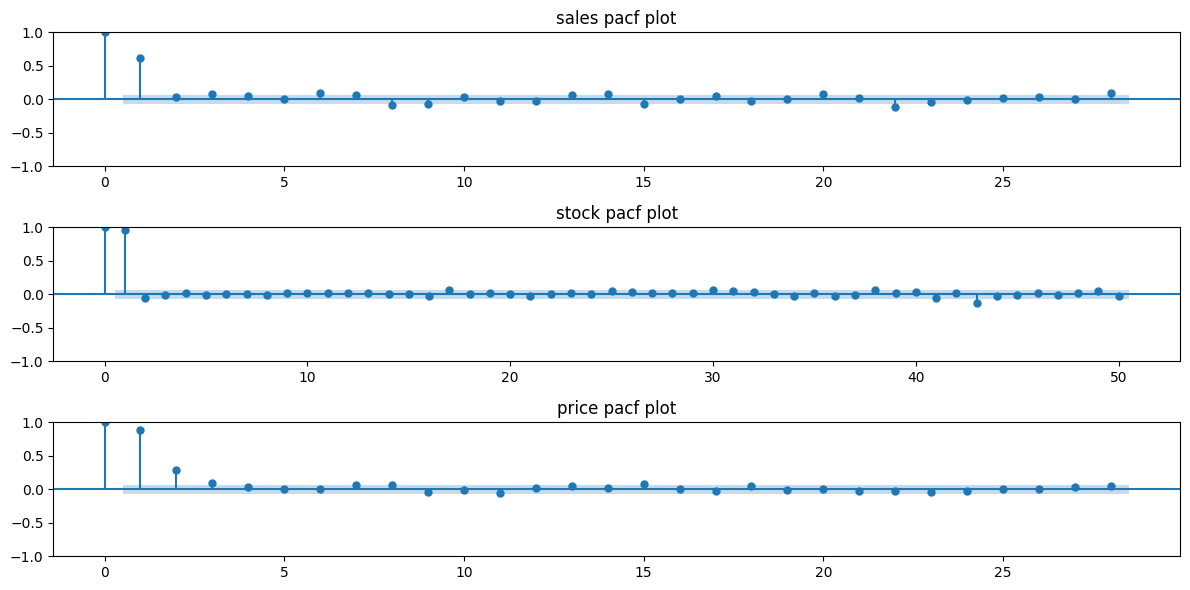

In [17]:
LAGS = [28, 50, 28]
_, axes = plt.subplots(len(train.columns), 1, figsize=(12,6))
for cname, ax, lags in zip(train.columns, axes.ravel(), LAGS):
    plot_pacf(train[cname], lags = lags,  ax=ax)
    ax.set_title(f'{cname} pacf plot')
plt.tight_layout()
plt.show()

<h2>ARIMA model</h2>

In [18]:
def evaluate_arima(train, test, p_values, d_values, q_values):
    best_mae, best_cfg = float('inf'), None
    for p in p_values:
        for d in d_values:
            for q in q_values:
                order = (p, d, q)
                try:
                    model = ARIMA(endog = train.values, order=order)
                    model_fit = model.fit()
                    predictions = model_fit.forecast(steps=len(test))
                    mae = mean_absolute_error(predictions, test)
                    print(f'Configuration: {order} - MAE: {mae}')
                    if mae < best_mae:
                        best_mae = mae
                        best_cfg = order
                except:
                    print(f'fit at order {order} failed')
                    continue 
    print(f'Best configuration: {best_cfg}\nBest MAE: {best_mae}')

To set the **p**,**d**,**q** parameters of the ARIMA model we refer to the analysis of stationarity and autocorrelation above: 
<ul>
<li>The stationarity of the time series suggested **d** = 0, so we'll use at most **d**={0,1} to avoid over-differencing</li> 
<li>The pacf plots suggest **p** between 0 and 2</li> 
<li>The acf plots suggest **q** values between 0 and 7.</li>
</ul>

In [19]:
sales_cfg = {'p_values' : range(2), 'd_values' : range(2), 'q_values': range(8)}
stock_cfg = {'p_values' : range(2), 'd_values' : range(2), 'q_values': range(8)}
price_cfg = {'p_values' : range(3), 'd_values' : range(2), 'q_values': range(8)}
col_dict = {'sales' : sales_cfg, 'stock' : stock_cfg, 'price' : price_cfg}

for cname in ['sales', 'stock', 'price']:
    print(cname.upper() + ' ARIMA STATS:')
    evaluate_arima(train[cname], test[cname], **col_dict[cname])
    print('-'*30)

SALES ARIMA STATS:
Configuration: (0, 0, 0) - MAE: 112.15232460827605
Configuration: (0, 0, 1) - MAE: 110.75706611510714
Configuration: (0, 0, 2) - MAE: 109.64610159707077
Configuration: (0, 0, 3) - MAE: 108.92202699857768
Configuration: (0, 0, 4) - MAE: 108.19185900428775
Configuration: (0, 0, 5) - MAE: 108.0638107271052
Configuration: (0, 0, 6) - MAE: 108.07559257141871
Configuration: (0, 0, 7) - MAE: 106.89224189378373
Configuration: (0, 1, 0) - MAE: 114.13333333333334
Configuration: (0, 1, 1) - MAE: 88.10228570624336
Configuration: (0, 1, 2) - MAE: 81.17361370429336
Configuration: (0, 1, 3) - MAE: 78.90268255852725
Configuration: (0, 1, 4) - MAE: 80.70745159719218
Configuration: (0, 1, 5) - MAE: 85.36751371678696
Configuration: (0, 1, 6) - MAE: 86.11494376706555
Configuration: (0, 1, 7) - MAE: 85.91876321857838
Configuration: (1, 0, 0) - MAE: 106.99791736369932
Configuration: (1, 0, 1) - MAE: 106.54612853357486
Configuration: (1, 0, 2) - MAE: 104.21146466591684
Configuration: (1, 0

/opt/conda/lib/python3.10/site-packages/statsmodels/base/model.py:607: ConvergenceWarning: Maximum Likelihood optimization failed to converge. Check mle_retvals
  warnings.warn("Maximum Likelihood optimization failed to "


Configuration: (1, 0, 0) - MAE: 0.5811826571755532
Configuration: (1, 0, 1) - MAE: 0.4637516102559364
Configuration: (1, 0, 2) - MAE: 0.46813068365775395
Configuration: (1, 0, 3) - MAE: 0.45848325523050304
Configuration: (1, 0, 4) - MAE: 0.4502860536239386
Configuration: (1, 0, 5) - MAE: 0.4199488386673321
Configuration: (1, 0, 6) - MAE: 0.38151866995721456
Configuration: (1, 0, 7) - MAE: 0.39625670882840175
Configuration: (1, 1, 0) - MAE: 0.35449999999999987
Configuration: (1, 1, 1) - MAE: 0.35449667563851006
Configuration: (1, 1, 2) - MAE: 0.2586636437311985
Configuration: (1, 1, 3) - MAE: 0.25731375126498074
Configuration: (1, 1, 4) - MAE: 0.2571556498455607


/opt/conda/lib/python3.10/site-packages/statsmodels/base/model.py:607: ConvergenceWarning: Maximum Likelihood optimization failed to converge. Check mle_retvals
  warnings.warn("Maximum Likelihood optimization failed to "


Configuration: (1, 1, 5) - MAE: 0.25718278910494574
Configuration: (1, 1, 6) - MAE: 0.33902665577034935
Configuration: (1, 1, 7) - MAE: 0.3383008571117591
Configuration: (2, 0, 0) - MAE: 0.530364738819874
Configuration: (2, 0, 1) - MAE: 0.46824063452583004


/opt/conda/lib/python3.10/site-packages/statsmodels/base/model.py:607: ConvergenceWarning: Maximum Likelihood optimization failed to converge. Check mle_retvals
  warnings.warn("Maximum Likelihood optimization failed to "


Configuration: (2, 0, 2) - MAE: 0.4681065367414757
Configuration: (2, 0, 3) - MAE: 0.46376846360677154


/opt/conda/lib/python3.10/site-packages/statsmodels/base/model.py:607: ConvergenceWarning: Maximum Likelihood optimization failed to converge. Check mle_retvals
  warnings.warn("Maximum Likelihood optimization failed to "


Configuration: (2, 0, 4) - MAE: 0.4477838323716639
Configuration: (2, 0, 5) - MAE: 0.394026517318876
Configuration: (2, 0, 6) - MAE: 0.38524202182246403


/opt/conda/lib/python3.10/site-packages/statsmodels/base/model.py:607: ConvergenceWarning: Maximum Likelihood optimization failed to converge. Check mle_retvals
  warnings.warn("Maximum Likelihood optimization failed to "


Configuration: (2, 0, 7) - MAE: 0.4262811890469434
Configuration: (2, 1, 0) - MAE: 0.35449999999999987
Configuration: (2, 1, 1) - MAE: 0.24527455935691206
Configuration: (2, 1, 2) - MAE: 0.2573744929726748
Configuration: (2, 1, 3) - MAE: 0.2594104553987633
Configuration: (2, 1, 4) - MAE: 0.2570492418752336


/opt/conda/lib/python3.10/site-packages/statsmodels/base/model.py:607: ConvergenceWarning: Maximum Likelihood optimization failed to converge. Check mle_retvals
  warnings.warn("Maximum Likelihood optimization failed to "


Configuration: (2, 1, 5) - MAE: 0.2569991209570556


/opt/conda/lib/python3.10/site-packages/statsmodels/base/model.py:607: ConvergenceWarning: Maximum Likelihood optimization failed to converge. Check mle_retvals
  warnings.warn("Maximum Likelihood optimization failed to "


Configuration: (2, 1, 6) - MAE: 0.3606189192342332
Configuration: (2, 1, 7) - MAE: 0.35624352219907823
Best configuration: (2, 1, 1)
Best MAE: 0.24527455935691206
------------------------------


/opt/conda/lib/python3.10/site-packages/statsmodels/base/model.py:607: ConvergenceWarning: Maximum Likelihood optimization failed to converge. Check mle_retvals
  warnings.warn("Maximum Likelihood optimization failed to "


We plot the predictions on the test set for the three series:

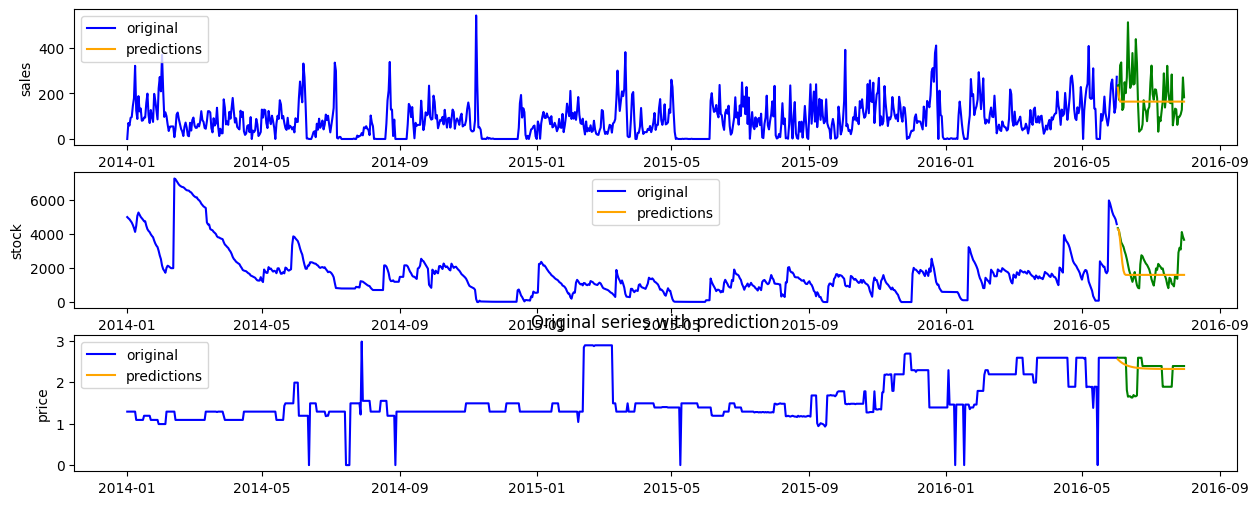

In [20]:
best_order = {'sales' : (0,1,3), 'stock' : (0,0,7), 'price' : (2,1,1)}
residuals_list = []
mae_list = []
_, axes = plt.subplots(len(train.columns), 1, figsize=(15,6))
for cname, ax in zip(train.columns, axes):
    model = ARIMA(endog = train[cname].values, order = best_order[cname])
    model_fit = model.fit()
    predictions = model_fit.forecast(steps=len(test))
    residuals_list.append(predictions - test[cname])
    mae_list.append(mean_absolute_error(predictions, test[cname]))
    sns.lineplot(x = train.index, y = train[cname], color = 'blue', label = 'original', ax=ax)
    sns.lineplot(x = test.index, y = test[cname], color = 'green', ax=ax)
    sns.lineplot(x = test.index, y = predictions, color = 'orange', label='predictions', ax=ax)
plt.title('Original series with prediction')
plt.legend()
plt.show()

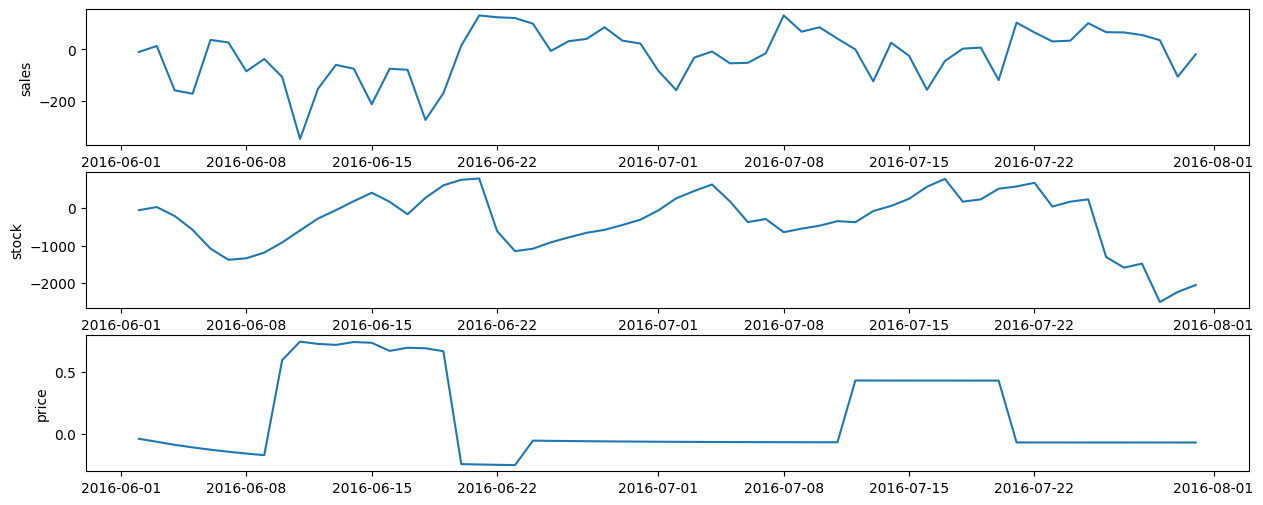

In [21]:
_, axes = plt.subplots(len(residuals_list), 1, figsize=(15,6))
for res, ax in zip(residuals_list, axes.ravel()):
    sns.lineplot(x = test.index, y = res, ax=ax)
plt.show()

From both the prediction and residual plots it's clear that we are missing some seasonal and/or cyclical components.
From now on we'll focus on the sales series.

In [22]:
print('ARIMA mae (for sales): ', mae_list[0])

ARIMA mae (for sales):  78.90268255852725


<h3>Seasonal decomposition</h3>

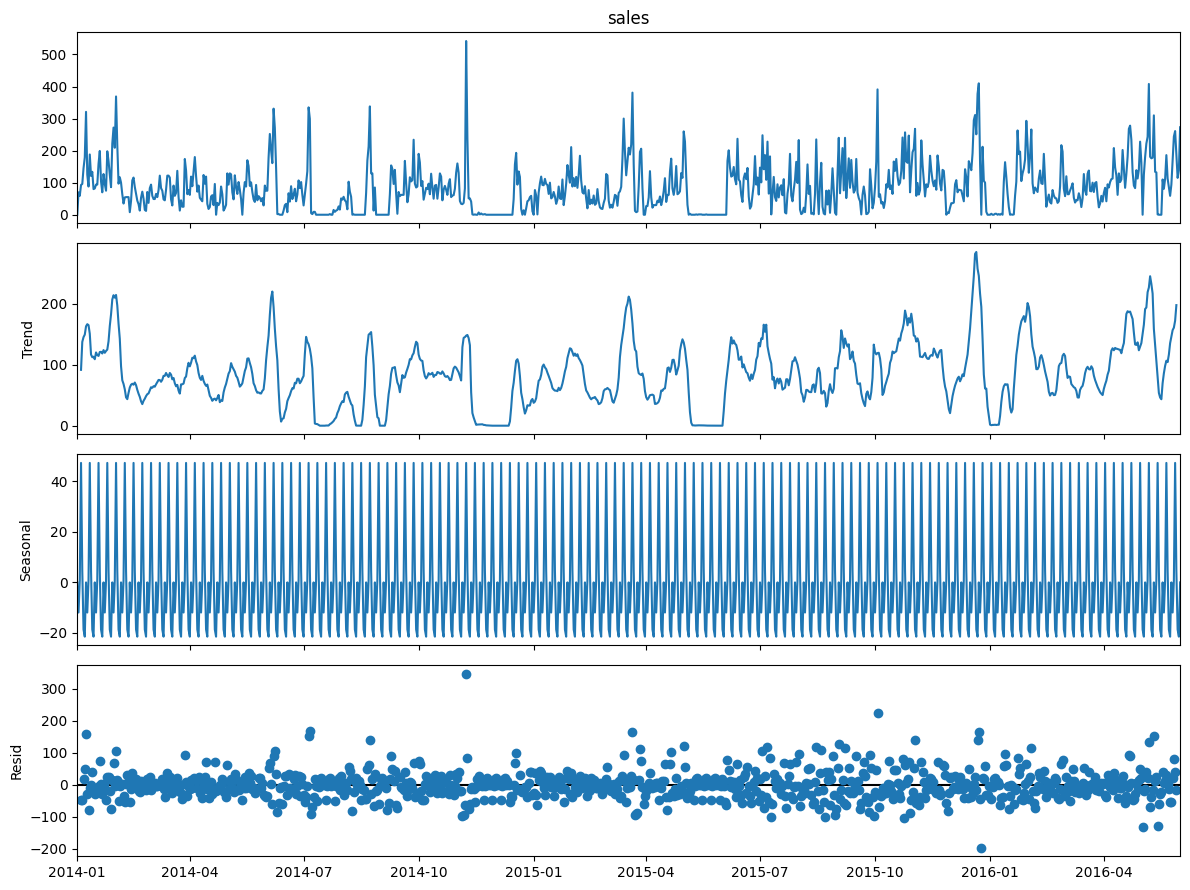

In [23]:
plt.rcParams['figure.figsize'] = (12,9)
result = seasonal_decompose(train['sales'], model='additive')
result.plot()
plt.show()

In [24]:
print('Mean residuals value: ', result.resid.mean())

Mean residuals value:  0.059965014577264435


There is no clear trend, but a clear seasonal component, moreover the residual have a mean close to zero which gives trust to the decomposition (a study of their distribution could be performed).
Let's take a closer look to the seasonal component:

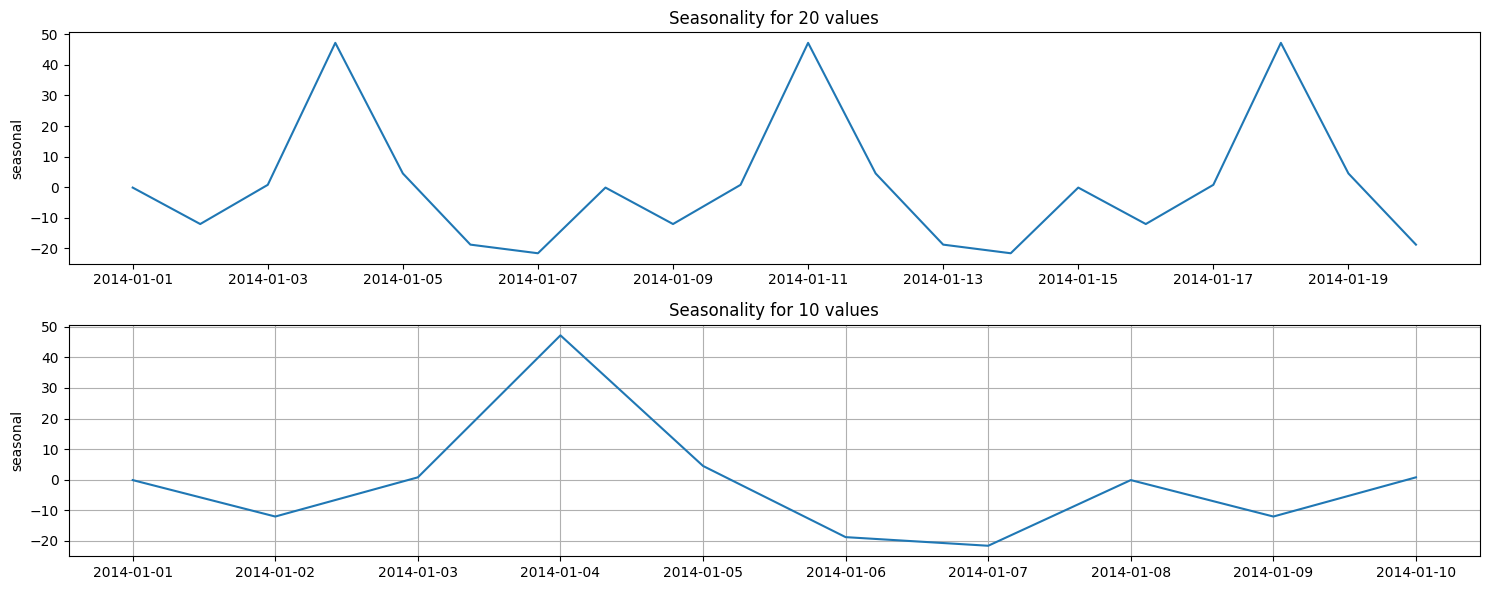

In [25]:
_, (ax0, ax1) = plt.subplots(2,1, figsize=(15, 6))
sns.lineplot(result.seasonal[:20], ax=ax0)
ax0.set_title('Seasonality for 20 values')
sns.lineplot(result.seasonal[:10], ax=ax1)
ax1.set_title('Seasonality for 10 values')
plt.grid()
plt.tight_layout()
plt.show()

A weekly frequency is observed.

<h2>SARIMA model</h2>

In [26]:
sarima_model = SARIMAX(train['sales'], order=(0, 1, 3), seasonal_order=(0, 1, 3, 7), enforce_stationarity=False, enforce_invertibility=False)
sarima_fit = sarima_model.fit(disp=False)#1-0-1
print(sarima_fit.summary())

                                     SARIMAX Results                                     
Dep. Variable:                             sales   No. Observations:                  883
Model:             SARIMAX(0, 1, 3)x(0, 1, 3, 7)   Log Likelihood               -4617.298
Date:                           Sat, 09 Nov 2024   AIC                           9248.596
Time:                                   13:45:49   BIC                           9281.812
Sample:                               01-01-2014   HQIC                          9261.319
                                    - 06-01-2016                                         
Covariance Type:                             opg                                         
                 coef    std err          z      P>|z|      [0.025      0.975]
------------------------------------------------------------------------------
ma.L1         -0.3622      0.024    -15.021      0.000      -0.409      -0.315
ma.L2         -0.2005      0.029     -6.889

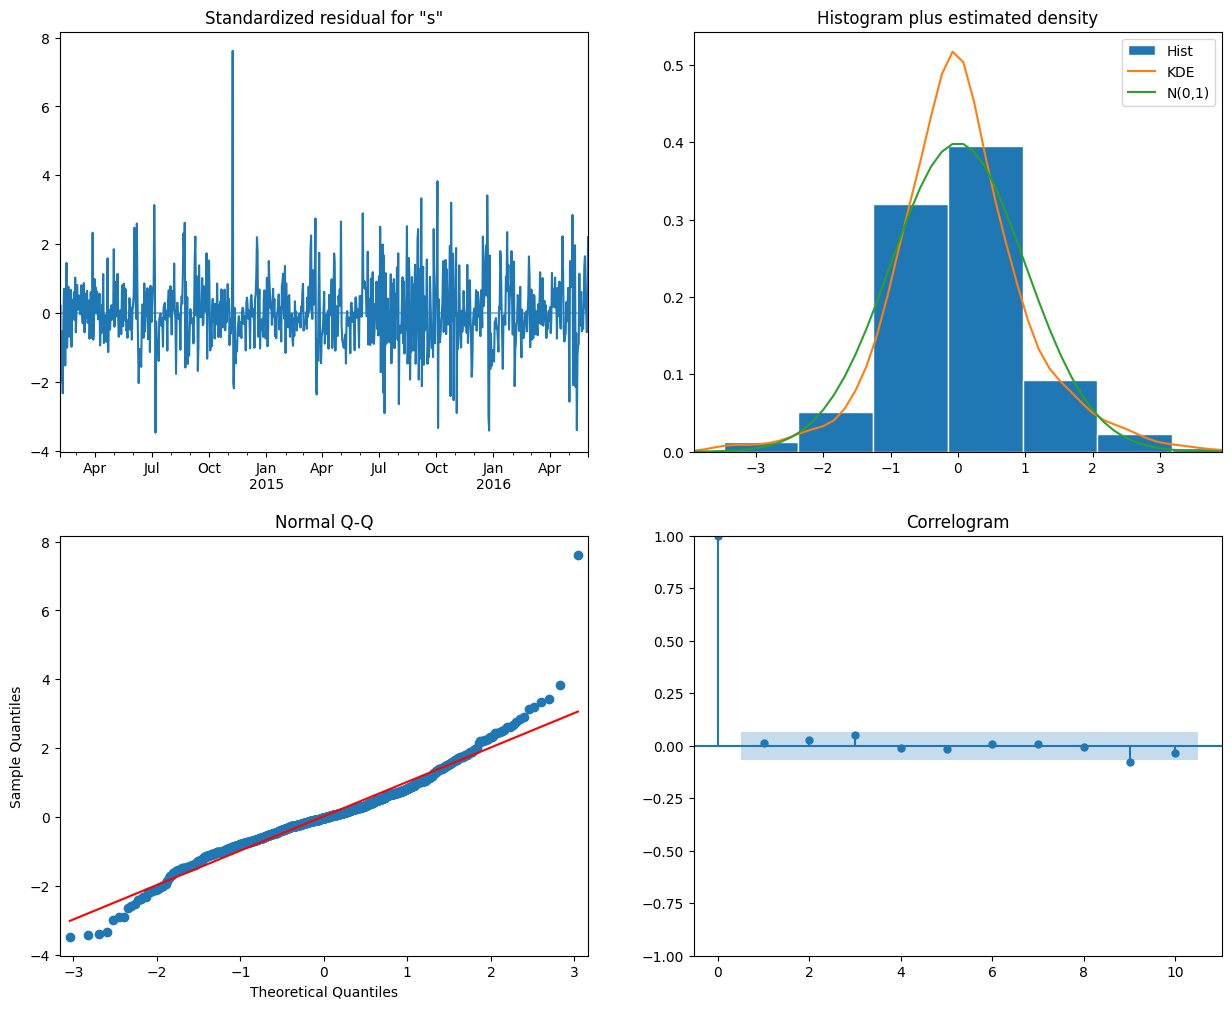

In [27]:
sarima_fit.plot_diagnostics(figsize=(15, 12))
plt.show()

While the residual mean is close to zero (similarly to white noise) the normal Q-Q plot still show skewness in the tails and the curve shape is not close to a normal distribution.

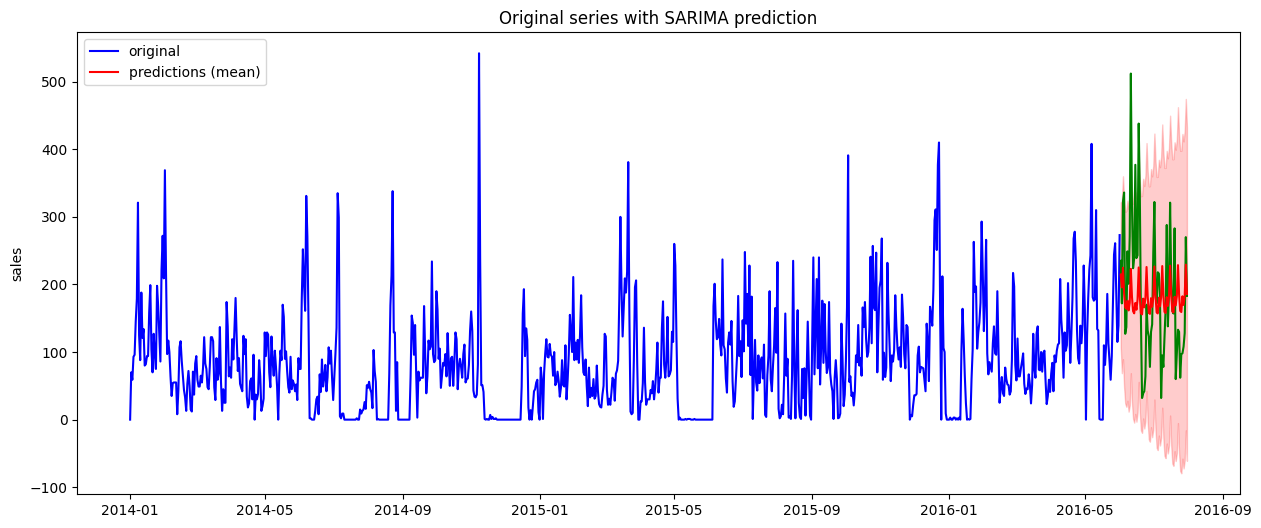

In [28]:
_, ax = plt.subplots(figsize=(15,6))
prediction = sarima_fit.get_prediction(start = test.index[0], end = test.index[-1], dynamic=False)
prediction_mean = prediction.predicted_mean
prediction_conf = prediction.conf_int()
sns.lineplot(x = train.index, y = train['sales'], color = 'blue', label = 'original', ax=ax)
sns.lineplot(x = test.index, y = test['sales'], color = 'green', ax=ax)
sns.lineplot(x = prediction_mean.index, y = prediction_mean, color = 'red', label='predictions (mean)', ax=ax)
plt.fill_between(prediction_conf.index, prediction_conf.iloc[:, 0], prediction_conf.iloc[:, 1], color='red', alpha=0.2)
plt.title('Original series with SARIMA prediction')
plt.legend(loc='upper left')
plt.show()

In [29]:
print('SARIMA mae: ', mean_absolute_error(prediction_mean, test['sales']))

SARIMA mae:  74.97796819525624


While the prediction is better than the one produced with the ARIMA model, it still fails to closely resemble the test data.

<h2>SARIMA model with resampling</h2>

We try another approach, that is to resample the dataframe in a weekly series:

In [30]:
weekly_sales = date_ff['sales'].resample('W').sum()
weekly_sales.head()

2014-01-05     318.0
2014-01-12    1167.0
2014-01-19     842.0
2014-01-26     838.0
2014-02-02    1500.0
Freq: W-SUN, Name: sales, dtype: float64

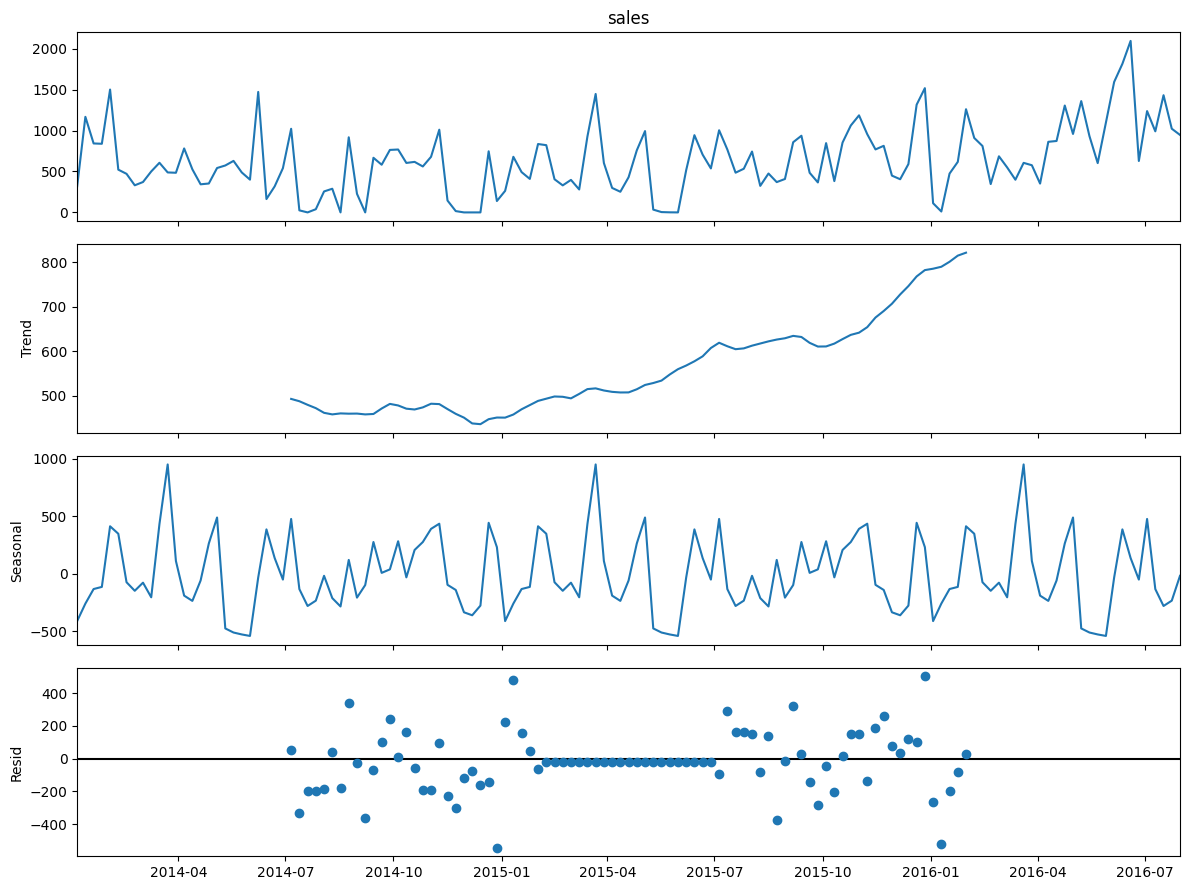

In [31]:
plt.rcParams['figure.figsize'] = (12,9)
weekly_decompose = seasonal_decompose(weekly_sales, model='additive')
weekly_decompose.plot()
plt.show()

We check the stationarity for th series as well as the first and second differentitation of the series:

In [32]:
adf_diff_df = pd.DataFrame()
results = adfuller(weekly_sales)
adf_diff_df = pd.concat([adf_diff_df, pd.DataFrame({'ADF': results[0], 'p-value' : results[1], 'Critical values': f'{results[4]}'}, index=[0])], axis=0)
for periods in range(1,3):
    results = adfuller(weekly_sales.diff(periods=periods).dropna())
    adf_diff_df = pd.concat([adf_diff_df, pd.DataFrame({'ADF': results[0], 'p-value' : results[1], 'Critical values': f'{results[4]}'}, index=[periods])], axis=0)
adf_diff_df

,ADF,p-value,Critical values
0,-2.378631,1.478586e-01,"{'1%': -3.482087964046026, '5%': -2.8842185101..."
1,-9.400474,6.207162e-16,"{'1%': -3.482087964046026, '5%': -2.8842185101..."
2,-5.493892,2.144842e-06,"{'1%': -3.4846672514209773, '5%': -2.885339750..."


Clearly the first differentiation is sufficient to satisfy stationarity.

[]

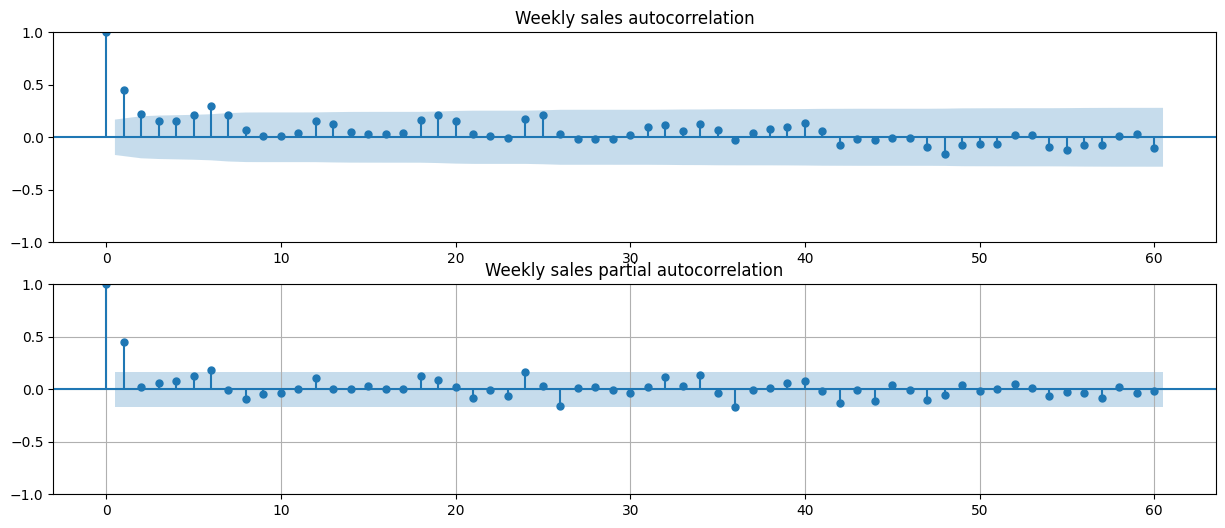

In [33]:
_, (ax0, ax1) = plt.subplots(2,1, figsize=(15,6))
plot_acf(weekly_sales, lags=60, ax=ax0)
plot_pacf(weekly_sales, lags=60, ax=ax1)
ax0.set_title('Weekly sales autocorrelation')
ax1.set_title('Weekly sales partial autocorrelation')
plt.grid()
plt.plot()

The most relevant correlations are at lag=1 for both ACF and PACF.

We create the train and test weekly series:

In [34]:
TEST_SIZE = 8
weekly_train, weekly_test = weekly_sales[:-TEST_SIZE], weekly_sales[-TEST_SIZE:]

In [35]:
p,d,q = 1,1,1
P,D,Q = 1,1,1
s = 52
sarima_model = SARIMAX(weekly_train, order = (p,d,q), seasonal_order = (P,D,Q,s))

In [36]:
sarima_model_fit = sarima_model.fit()
print(sarima_model_fit.summary())

RUNNING THE L-BFGS-B CODE

           * * *

Machine precision = 2.220D-16
 N =            5     M =           10

At X0         0 variables are exactly at the bounds

At iterate    0    f=  4.41717D+00    |proj g|=  1.29895D-01


 This problem is unconstrained.



At iterate    5    f=  4.37601D+00    |proj g|=  2.15311D-03

At iterate   10    f=  4.37414D+00    |proj g|=  4.91419D-03

At iterate   15    f=  4.37391D+00    |proj g|=  3.69877D-03

At iterate   20    f=  4.35689D+00    |proj g|=  1.37990D-02

At iterate   25    f=  4.34059D+00    |proj g|=  2.70558D-03

At iterate   30    f=  4.33956D+00    |proj g|=  3.25877D-04

At iterate   35    f=  4.33956D+00    |proj g|=  1.32053D-03

At iterate   40    f=  4.33953D+00    |proj g|=  6.28374D-04

At iterate   45    f=  4.33952D+00    |proj g|=  2.95578D-04


/opt/conda/lib/python3.10/site-packages/statsmodels/base/model.py:607: ConvergenceWarning: Maximum Likelihood optimization failed to converge. Check mle_retvals
  warnings.warn("Maximum Likelihood optimization failed to "



At iterate   50    f=  4.33952D+00    |proj g|=  2.21285D-04

           * * *

Tit   = total number of iterations
Tnf   = total number of function evaluations
Tnint = total number of segments explored during Cauchy searches
Skip  = number of BFGS updates skipped
Nact  = number of active bounds at final generalized Cauchy point
Projg = norm of the final projected gradient
F     = final function value

           * * *

   N    Tit     Tnf  Tnint  Skip  Nact     Projg        F
    5     50     62      1     0     0   2.213D-04   4.340D+00
  F =   4.3395173697966793     

STOP: TOTAL NO. of ITERATIONS REACHED LIMIT                 
                                     SARIMAX Results                                      
Dep. Variable:                              sales   No. Observations:                  127
Model:             SARIMAX(1, 1, 1)x(1, 1, 1, 52)   Log Likelihood                -551.119
Date:                            Sat, 09 Nov 2024   AIC                           1112.2

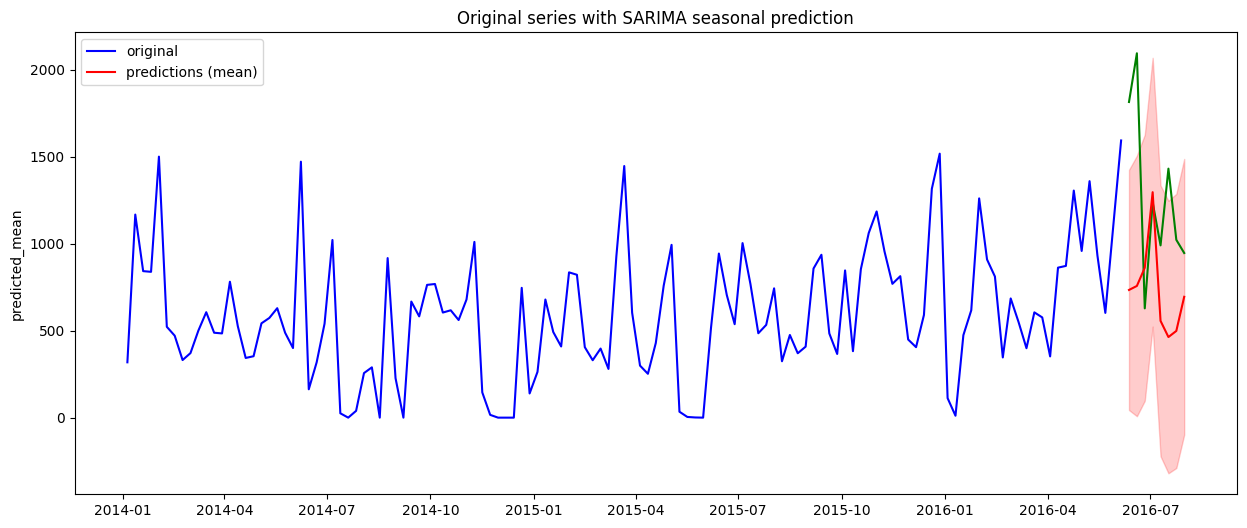

In [37]:
_, ax = plt.subplots(figsize=(15,6))
prediction = sarima_model_fit.get_prediction(start = weekly_test.index[0], end = weekly_test.index[-1], dynamic=False)
prediction_mean = prediction.predicted_mean
prediction_conf = prediction.conf_int()
sns.lineplot(x = weekly_train.index, y = weekly_train.values, color = 'blue', label = 'original', ax=ax)
sns.lineplot(x = weekly_test.index, y = weekly_test.values, color = 'green', ax=ax)
sns.lineplot(x = prediction_mean.index, y = prediction_mean, color = 'red', label='predictions (mean)', ax=ax)
plt.fill_between(prediction_conf.index, prediction_conf.iloc[:, 0], prediction_conf.iloc[:, 1], color='red', alpha=0.2)
plt.title('Original series with SARIMA seasonal prediction')
plt.legend(loc='upper left')
plt.show()

In [38]:
print('SARIMA model with weekly resample: ', mean_absolute_error(prediction_mean, weekly_test))

SARIMA model with weekly resample:  610.7705907267341


The model now is more responsive to the seasonality of the series, but still fails to predict correctly the sales vales.

<h2>XGBRegressor</h2>

Finally we try and use a XGBRegressor, with sales as dependent variables and the rest of the dataframe as independent variables; we also add a revenue series as derived feature from price and sales:

In [39]:
train['revenue'] = train['price']*train['sales']
test['revenue'] = test['price']*test['sales']

In [40]:
train.head()

,sales,stock,price,revenue
2014-01-01,0.0,4972.0,1.29,0.00
2014-01-02,70.0,4902.0,1.29,90.30
2014-01-03,59.0,4843.0,1.29,76.11
2014-01-04,93.0,4750.0,1.29,119.97
2014-01-05,96.0,4654.0,1.29,123.84


In [41]:
X_train = train[['stock', 'price', 'revenue']]
y_train = train['sales']

X_test = test[['stock', 'price', 'revenue']]
y_test = test['sales']

In [42]:
xgbr_model = XGBRegressor(n_estimators = 100, early_stopping_rounds=50)
xgbr_fit = xgbr_model.fit(X_train, y_train, eval_set = [(X_test, y_test)], verbose=2)

[0]	validation_0-rmse:109.71046
[2]	validation_0-rmse:75.40505
[4]	validation_0-rmse:52.46293
[6]	validation_0-rmse:44.26413
[8]	validation_0-rmse:34.13793
[10]	validation_0-rmse:28.27225
[12]	validation_0-rmse:24.95086
[14]	validation_0-rmse:23.08967
[16]	validation_0-rmse:22.02826
[18]	validation_0-rmse:21.68723
[20]	validation_0-rmse:21.44602
[22]	validation_0-rmse:21.42768
[24]	validation_0-rmse:21.44010
[26]	validation_0-rmse:21.42517
[28]	validation_0-rmse:21.38091
[30]	validation_0-rmse:21.36140
[32]	validation_0-rmse:21.37034
[34]	validation_0-rmse:21.36752
[36]	validation_0-rmse:21.43751
[38]	validation_0-rmse:21.40695
[40]	validation_0-rmse:21.41688
[42]	validation_0-rmse:21.43392
[44]	validation_0-rmse:21.43458
[46]	validation_0-rmse:21.47229
[48]	validation_0-rmse:21.49065
[50]	validation_0-rmse:21.49561
[52]	validation_0-rmse:21.49760
[54]	validation_0-rmse:21.49272
[56]	validation_0-rmse:21.48777
[58]	validation_0-rmse:21.47901
[60]	validation_0-rmse:21.45791
[62]	validat

In [43]:
predictions = xgbr_model.predict(X_test)
print('XGBRegressor mae: ', mean_absolute_error(predictions, y_test))

XGBRegressor mae:  12.244281260172526


The predictions mean absolute error is the best of all the model considered, and the plot below confir, how the regressor captured the fluctuations of the data:

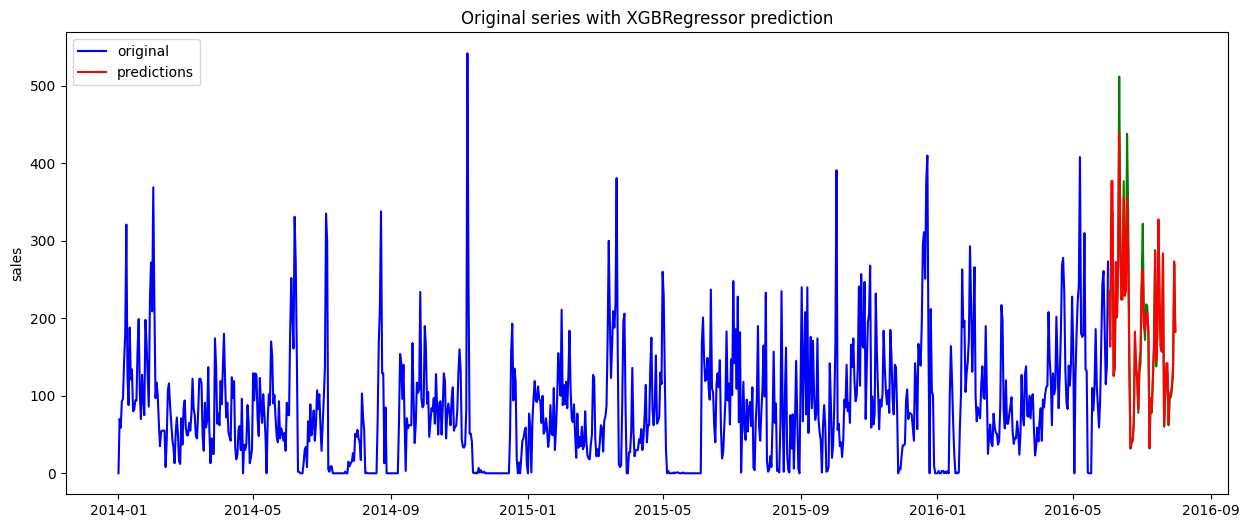

In [44]:
_, ax = plt.subplots(figsize=(15,6))
sns.lineplot(x = train.index, y = train['sales'], color = 'blue', label = 'original', ax=ax)
sns.lineplot(x = test.index, y = test['sales'], color = 'green', ax=ax)
sns.lineplot(x = test.index, y = predictions, color = 'red', label='predictions', ax=ax)
plt.title('Original series with XGBRegressor prediction')
plt.legend(loc='upper left')
plt.show()